In [14]:
"""
@Author: blankxiao
@file: A_1.py
@Created: 2024-09-05 21:24
@Desc: A题第一问 所有点在300秒内的运动轨迹
"""
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

# 模拟的时间 s
time = 300
# 螺线距离 m


# 板凳个数 第一节为龙头
num_point = 224


# 龙头初始位置 第一圈角度为0 
loong_head_speed = 1.0



def get_alpha_0(t: int, spiral_d = 0.55):
    """
    获取龙头的角度
    @param t: 时间s
    @return: alpha0 角度 
    """
    # spiral_distance 为螺距
    return 32 * np.pi - sp.sqrt((32 * np.pi) ** 2 - 4 * np.pi / spiral_d * t)

def get_r_0(alpha_0: int, spiral_d = 0.55):
    """
    @param alpha_0: alpha0角度
    @return: r0 极径
    """
    return 16 * spiral_d - spiral_d / (2 * np.pi) * alpha_0


def get_alpha_i(r_i: int, spiral_d = 0.55):
    """
    获取r_i的半径
    @param alpha_i: 角度
    @return: r_i 半径 m
    """
    return 32 * np.pi - 2 * np.pi / spiral_d * r_i

def get_r_i(r_i_pre: int, point_index: int, spiral_d = 0.55):
    """
    获取alpha_i的半径
    @param r_i: 半径 cm
    @return: alpha_i 角度
    """
    # 把手到边缘的距离
    AD_d = 0.275

    # 龙头两个把手的间距
    L_loong_head = 3.41 - 2 * AD_d
    # 龙身两个把手的间距
    L_loong_body = 2.20 - 2 * AD_d

    bandeng_len = L_loong_body
    if point_index == 1:
        bandeng_len = L_loong_head

    # 定义符号变量
    r_i = sp.symbols('r_i')

    def equation(r_i):
        return r_i_pre ** 2 + r_i ** 2 - 2 * r_i_pre * r_i * sp.cos(2 * sp.pi / spiral_d * (r_i - r_i_pre)) - bandeng_len ** 2

    eq = equation(r_i)
    r_i = sp.nsolve(eq, r_i, r_i_pre, tolerance=1e-6)  # 使用 nsolve 求解，初始猜测值为 1.0

    return r_i


def plot_polar_scatter(theta, r, color='blue', marker='o', s=30, alpha=0.8, figsize=(8, 6), line_color='red', line_width=1):
    """
    绘制极坐标散点图，并连接每个点

    theta: 角度值的列表（弧度制）
    r: 半径值的列表
    color: 散点颜色
    marker: 散点形状
    s: 散点大小
    alpha: 散点透明度
    figsize: 图像大小
    line_color: 连接线的颜色
    line_width: 连接线的宽度
    """
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, projection='polar')  # 创建极坐标子图
    
    # 绘制散点
    ax.scatter(theta, r, color=color, marker=marker, s=s, alpha=alpha)
    
    # 绘制连接线
    ax.plot(theta, r, color=line_color, linewidth=line_width)
    
    plt.grid(True)
    plt.show()

def get_x_y(alpha, r):
    """
    获取x,y坐标
    @param alpha: 角度
    @param r: 半径
    @return: x,y坐标
    """
    return r * sp.cos(-alpha), r * sp.sin(-alpha)


def get_v_i(v_i_pre: int, r_i_pre: int, r_i: int, spiral_d = 0.55):
    """
    获取速度v_i
    @param v_i_pre: 上一个速度
    @param r_i_pre: 上一个点的极径
    @param r_i: 当前极径
    @return: v_i
    """
    coeff_of_v_i_pre = (1 - r_i / r_i_pre * sp.cos(2 * np.pi / spiral_d * (r_i - r_i_pre)) - 2 * np.pi * r_i / spiral_d * sp.sin(2 * np.pi / spiral_d * (r_i - r_i_pre)))
    coeff_of_v_i = (1 - r_i_pre / r_i * sp.cos(2 * np.pi / spiral_d * (r_i - r_i_pre)) + 2 * np.pi * r_i_pre / spiral_d * sp.sin(2 * np.pi / spiral_d * (r_i - r_i_pre)))
    return - coeff_of_v_i_pre * v_i_pre / coeff_of_v_i


In [15]:

def plot_polar_scatter(theta, r, color='blue', marker='o', s=30, alpha=0.8, figsize=(8, 6), line_color='red', line_width=1):
    """
    绘制极坐标散点图，并连接每个点

    theta: 角度值的列表（弧度制）
    r: 半径值的列表
    color: 散点颜色
    marker: 散点形状
    s: 散点大小
    alpha: 散点透明度
    figsize: 图像大小
    line_color: 连接线的颜色
    line_width: 连接线的宽度
    """
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, projection='polar')  # 创建极坐标子图
    
    # 绘制散点
    ax.scatter(theta, r, color=color, marker=marker, s=s, alpha=alpha)
    
    # 绘制连接线
    ax.plot(theta, r, color=line_color, linewidth=line_width)
    
    plt.grid(True)
    plt.show()
df_xyv = pd.DataFrame(index=pd.MultiIndex.from_product([range(num_point), ['x', 'y', "v"]]), columns=[f'{i} s' for i in range(time + 1)])

df_rav = pd.DataFrame(index=pd.MultiIndex.from_product([range(num_point), ['r', 'alpha', "v"]]), columns=range(time + 1))

df_position = pd.DataFrame(index=[
    [f'龙头{s} (m)' for s in ["x", "y"]] + 
    [f'第{i}节龙身{s} (m)' for i in range(1, num_point - 2) for s in ["x", 'y']] +
    [f'龙尾{s} (m)' for s in ["x", 'y']] +
    [f'龙尾（后）{s} (m)' for s in ["x", 'y']]
],
columns=[f'{t} s' for t in range(time + 1)])

df_velocity = pd.DataFrame(index=[
    ['龙头 (m/s)'] + [f'第{i}节龙身  (m/s)' for i in range(1, num_point - 2)] +
    ['龙尾  (m/s)', '龙尾（后） (m/s)']
], columns=[f'{t} s' for t in range(time + 1)])



In [17]:

for point_index in range(num_point):
    for t in range(430):
        if point_index != 0:
            r_i_pre=df_rav[t][point_index - 1, 'r']
            v_i_pre=df_rav[t][point_index - 1, 'v']

            cur_r = get_r_i(r_i_pre=r_i_pre, point_index=point_index)
            cur_alpha = get_alpha_i(r_i=cur_r)
            cur_r = get_r_i(r_i_pre=r_i_pre, point_index=point_index)
            cur_alpha = get_alpha_i(r_i=cur_r)

            cur_v = get_v_i(v_i_pre=v_i_pre, r_i_pre=r_i_pre, r_i=cur_r)
        else:
            cur_alpha = get_alpha_0(t)
            cur_r = get_r_0(cur_alpha)
            cur_v = loong_head_speed

        cur_x, cur_y = get_x_y(alpha=cur_alpha, r=cur_r)
        
        # 记录当前的 r 和 alpha
        df_rav.at[(point_index, 'r'), t] = cur_r
        df_rav.at[(point_index, 'alpha'), t] = cur_alpha
        df_rav.at[(point_index, 'v'), t] = cur_v

        df_xyv.at[(point_index, 'x'), t] = cur_x
        df_xyv.at[(point_index, 'y'), t] = cur_y
        df_xyv.at[(point_index, 'v'), t] = cur_v


ValueError: Could not find root within given tolerance. (123.457991893873503573 > 2.16840434497100886801e-19)
Try another starting point or tweak arguments.

In [ ]:



if point_index > 2:
    alpha_0 = df_rav.at[(0, 'alpha'), t]
    r_0 = df_rav.at[(0, 'r'), t]

    alpha_1 = df_rav.at[(1, 'alpha'), t]
    r_1 = df_rav.at[(1, 'r'), t]

    alpha_i_pre = df_rav.at[(point_index - 1, 'alpha'), t]
    r_i_pre = df_rav.at[(point_index - 1, 'r'), t]

    B_i, B_i_pre, C_0 = get_pos_of_corner(alpha_0=alpha_0, r_0=r_0, alpha_1=alpha_1, r_1=r_1, alpha_i_pre=alpha_i_pre, r_i_pre=r_i_pre, alpha_i=cur_alpha, r_i=cur_r )
    df_coner.at[(point_index, 'B_i'), t] = B_i
    df_coner.at[(point_index, 'B_i_pre'), t] = B_i_pre
    df_coner.at[(point_index, 'C_0'), t] = C_0
    if are_collinear(B_i, B_i_pre, C_0):
        print(f'{t}时刻发现碰撞点 r_0为{r_0}')
        crash = True
        break


In [34]:
time_range = range(430, 434)
for t in time_range:
    for point_index in range(num_point):
        if point_index != 0:
            r_i_pre=df_rav[t][point_index - 1, 'r']
            v_i_pre=df_rav[t][point_index - 1, 'v']

            cur_r = get_r_i(r_i_pre=r_i_pre, point_index=point_index)
            cur_alpha = get_alpha_i(r_i=cur_r)
            cur_r = get_r_i(r_i_pre=r_i_pre, point_index=point_index)
            cur_alpha = get_alpha_i(r_i=cur_r)

            cur_v = get_v_i(v_i_pre=v_i_pre, r_i_pre=r_i_pre, r_i=cur_r)
        else:
            cur_alpha = get_alpha_0(t)
            cur_r = get_r_0(cur_alpha)
            cur_v = loong_head_speed

        cur_x, cur_y = get_x_y(alpha=cur_alpha, r=cur_r)
        
        # 记录当前的 r 和 alpha
        df_rav.at[(point_index, 'r'), t] = cur_r
        df_rav.at[(point_index, 'alpha'), t] = cur_alpha
        df_rav.at[(point_index, 'v'), t] = cur_v

        df_xyv.at[(point_index, 'x'), t] = cur_x
        df_xyv.at[(point_index, 'y'), t] = cur_y
        df_xyv.at[(point_index, 'v'), t] = cur_v


In [37]:
df_rav
time_range = range(430, 434)


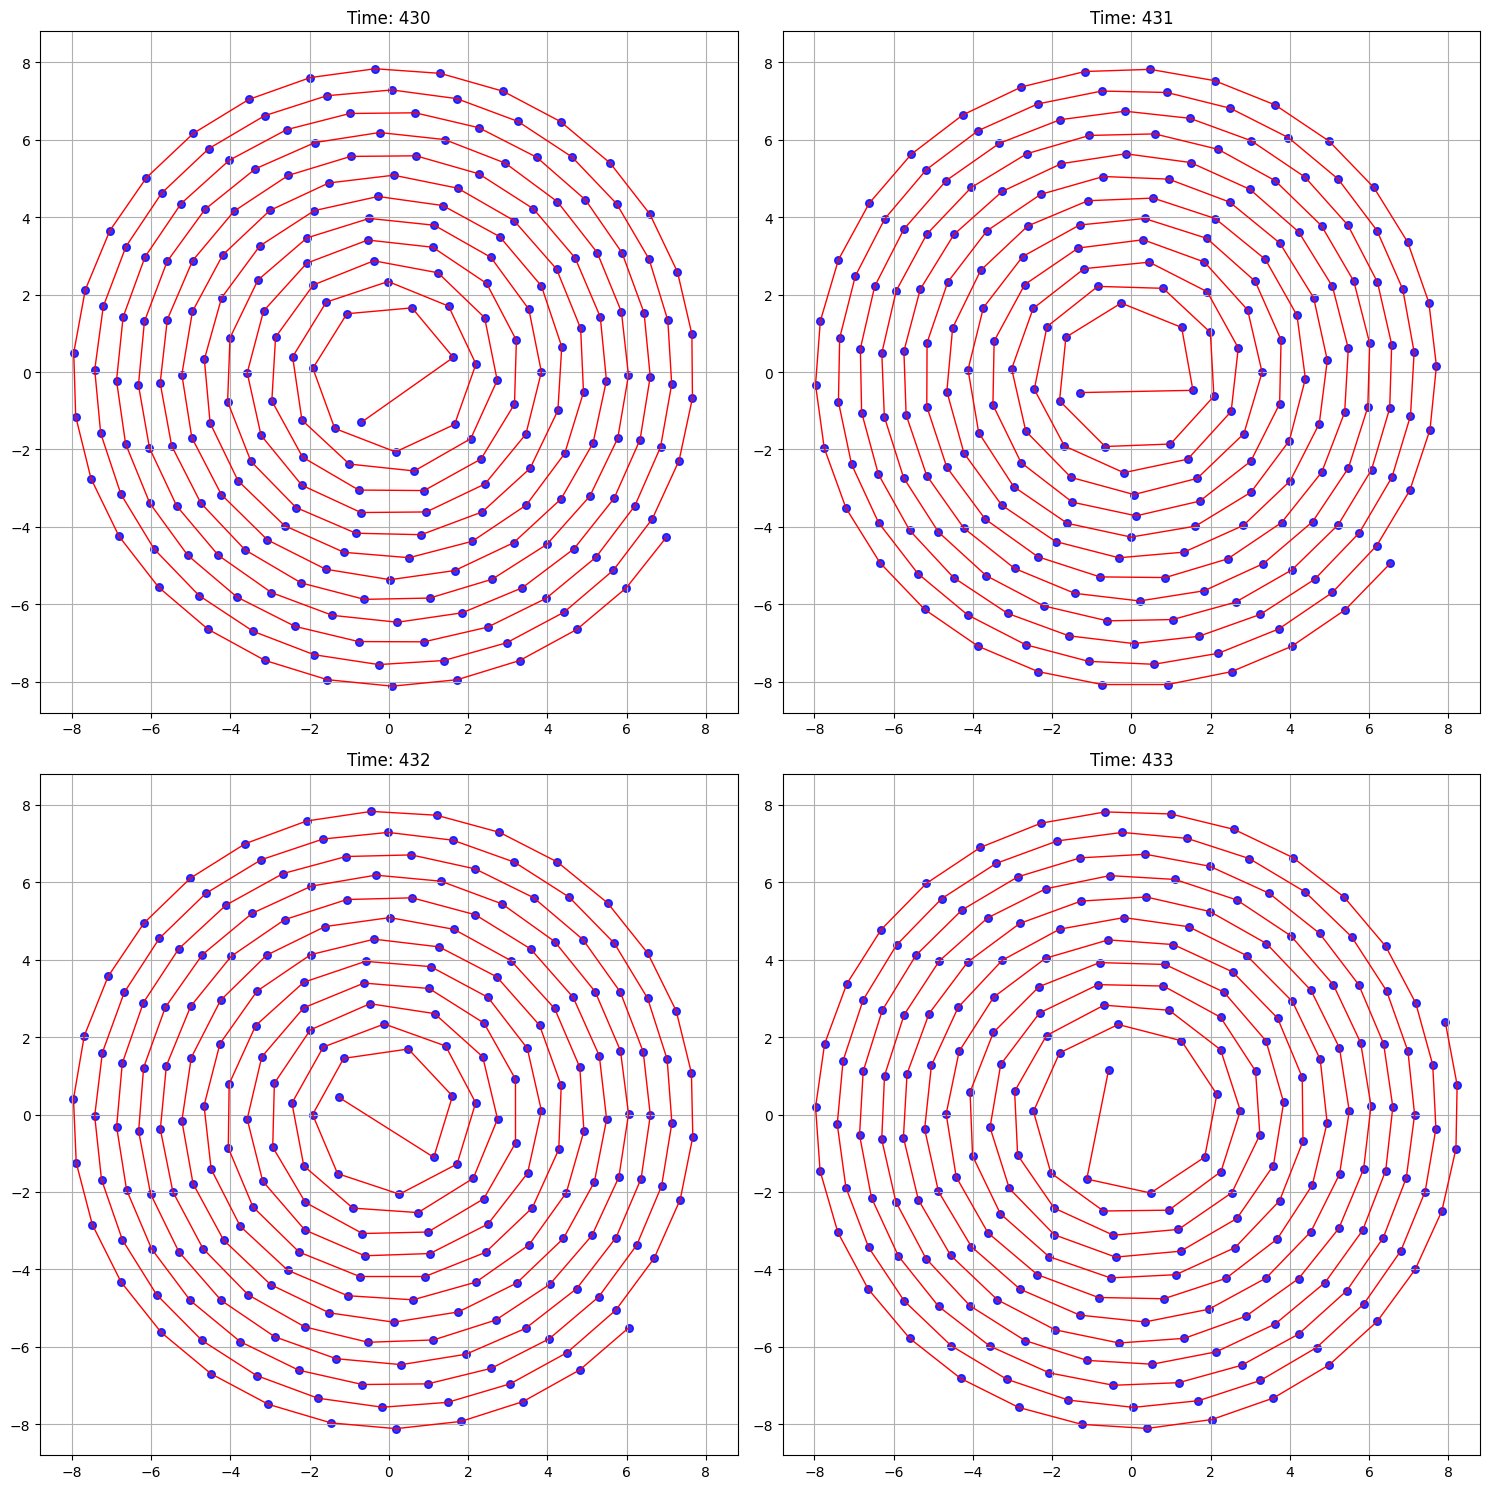

In [38]:
import matplotlib.pyplot as plt
import numpy as np


# 设置绘图参数
color = 'blue'
marker = 'o'
s = 30
alpha = 0.8
line_color = 'red'
line_width = 1
spiral_color = 'green'
spiral_width = 1

# 计算子图的行数和列数
num_plots = len(time_range)
num_rows = int(np.ceil(np.sqrt(num_plots)))
num_cols = int(np.ceil(num_plots / num_rows))

# 创建一个包含子图的图形
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# 遍历每个时间点
for i, t in enumerate(time_range):
    # 获取数据
    x = df_xyv[t][:, "x"]
    y = df_xyv[t][:, "y"]

    # 获取当前子图
    ax = axes[i // num_cols, i % num_cols]

    # 绘制散点
    ax.scatter(x, y, c=color, marker=marker, s=s, alpha=alpha)

    # 绘制连接线
    ax.plot(x, y, c=line_color, linewidth=line_width)

    # 设置 x 和 y 轴的范围
    ax.set_xlim([-0.55 * 16, 0.55 * 16])
    ax.set_ylim([-0.55 * 16, 0.55 * 16])

    # 设置网格
    ax.grid(True)

    # 设置子图标题
    ax.set_title(f'Time: {t}')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()